In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from random import random
import random
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
plt.ion()   # interactive mode

In [3]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [4]:
size= 256
mean = (0.485, 0.456, 0.406)
std = (0.229,0.224, 0.225)
batch_size = 32

In [5]:
trainlists = pd.read_csv('./train_labels.csv')

npdatapath_list=np.array(trainlists)
trainlist, testlist = train_test_split(npdatapath_list, test_size = 0.2)

trainlists.head()

,path,target
0,train_1111.png,0
1,train_5746.png,0
2,train_6365.png,0
3,train_0152.png,1
4,train_0928.png,1


In [6]:
train_path =[]
temp = []
train_label = []
for i,f in enumerate(trainlist):
    temp.append(trainlist[i][0])
    train_label.append(trainlist[i][1])
    train_path.append('./input/train_images/'+temp[i])

test_path =[]
temp2 = []
test_label = []
for i,f in enumerate(testlist):
    temp2.append(testlist[i][0])
    test_label.append(testlist[i][1])
    test_path.append('./input/train_images/'+temp2[i])

In [13]:
def RandomErasing():
    '''
    probability: The probability that the operation will be performed.
    sl: min erasing area
    sh: max erasing area
    r1: min aspect ratio
    mean: erasing value
    -------------------------------------------------------------------------------------
    '''
    probability = 0.5                    #この処理を行う確率
    mean = [0.4914, 0.4822, 0.4465]      # RGBそれぞれの画素値（中間色）
    sl = 0.02                            #マスクする場合の最低の割合
    sh = 0.4                             #マスクする場合の最高の割合
    r1 = 0.3                             #マスクの縦横比

    if random.uniform(0, 1) > probability:  #乱数がprobability(0.5)を超えたら
        return img                          #画像をそのまま返す

        for attempt in range(100):
            area = img.size()[1] * img.size()[2]   #画像サイズを取得
       
            target_area = random.uniform(sl, sh) * area  #面積を決定
            aspect_ratio = random.uniform(r1, 1/r1)      #縦横比を決定

            h = int(round(math.sqrt(target_area * aspect_ratio))) #マスクの高さを決定
            w = int(round(math.sqrt(target_area / aspect_ratio))) #マスクの幅を決定
#img.size() = [3,256,256]
            if w < img.size()[2] and h < img.size()[1]: #画像のサイズをマスクがオーバーしていないことを確認
                x1 = random.randint(0, img.size()[1] - h)     #左上のx座標を決定
                y1 = random.randint(0, img.size()[2] - w)     #左上のy座標を決定
                if img.size()[0] == 3:                  #3チャンネル画像の場合
                    img[0, x1:x1+h, y1:y1+w] = mean[0]  #色で埋める
                    img[1, x1:x1+h, y1:y1+w] = mean[1]
                    img[2, x1:x1+h, y1:y1+w] = mean[2]
                else:                                   #グレースケール画像の場合
                    img[0, x1:x1+h, y1:y1+w] = mean[0]
            
                return img

    

In [14]:
def random_erasing(img, p=0.5, sl=0.02, sh=0.4, r1=0.3, r2=3.3):
    target_img = img.copy()

    if p < : random.uniform(0, 1)# RandomErasingを実行しない
        return target_img 

    H, W, _ = target_img.shape
    S = H * W

    while True:
        Se = np.random.uniform(sl, sh) * S # 画像に重畳する矩形の面積
        re = np.random.uniform(r1, r2) # 画像に重畳する矩形のアスペクト比

        He = int(np.sqrt(Se * re)) # 画像に重畳する矩形のHeight
        We = int(np.sqrt(Se / re)) # 画像に重畳する矩形のWidth

        xe = np.random.randint(0, W) # 画像に重畳する矩形のx座標
        ye = np.random.randint(0, H) # 画像に重畳する矩形のy座標

        if xe + We <= W and ye + He <= H:
            # 画像に重畳する矩形が画像からはみ出していなければbreak
            break

    mask = np.random.randint(0, 255, (He, We, 3)) # 矩形がを生成 矩形内の値はランダム値
    target_img[ye:ye + He, xe:xe + We, :] = mask # 画像に矩形を重畳

    return target_img

SyntaxError: invalid syntax (<ipython-input-14-9fa124174b66>, line 4)

In [15]:
class ImageTransform():
    """
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),  # データオーギュメンテーション
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation((180,180)),# データオーギュメンテーション
                transforms.ToTensor(),# テンソルに変換
                #transforms.Normalize(mean, std),
                transforms.RandomErasing()# 標準化
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),  # リサイズ
                transforms.CenterCrop(resize),  # 画像中央をresize×resizeで切り取り
                transforms.ToTensor(),  # テンソルに変換
                #transforms.Normalize(mean, std)  # 標準化
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

In [16]:
class yeardetectDataset(torch.utils.data.Dataset):


    def __init__(self, transform=None, phase='train'):
        #self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        if self.phase == 'train':
            return len(train_path)
        if self.phase == 'val':
            return len(test_path)
        #return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''
        if self.phase == 'train':
            img_path = train_path[index]
            img = Image.open(img_path)
        elif self.phase =='val':
            img_path = test_path[index]
            img = Image.open(img_path)
        # index番目の画像をロード
        #img_path = self.file_list[index]
        #img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(img, self.phase)  # torch.Size([3, 224, 224])

        # 画像のラベル取得
        if self.phase == "train":
            label = train_label[index]
        elif self.phase == "val":
            label = test_label[index]
  
        
        

        return img_transformed, label
    
train_dataset = yeardetectDataset(
    transform=ImageTransform(size, mean, std), phase='train')

val_dataset = yeardetectDataset(
     transform=ImageTransform(size, mean, std), phase='val')

# 動作確認
index = 80
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])


torch.Size([3, 256, 256])
23


In [17]:
# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作確認
batch_iterator = iter(dataloaders_dict["train"])  # イテレータに変換
inputs, labels = next(batch_iterator) 
# 1番目の要素を取り出す
print(inputs.size())
print(labels.size())


torch.Size([32, 3, 256, 256])
torch.Size([32])


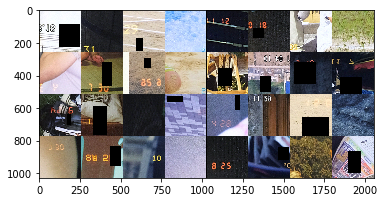

In [18]:
import matplotlib.pyplot as plt
img = torchvision.utils.make_grid(inputs,nrow=8, padding=1)
plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
plt.show()

In [19]:
nfd = 128

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)
    
class DNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, nfd//8 , 3 , 1 , 1 ,bias=False),
            
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nfd//8, nfd//4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfd//4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(nfd//4, nfd//4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(nfd//4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(nfd//4, nfd//2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfd//2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(nfd//2, nfd//2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(nfd//2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(nfd//2, nfd, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfd),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(nfd, nfd, 3, 1, 1, bias=False),
            nn.BatchNorm2d(nfd),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.2),
            
            nn.Conv2d(nfd, nfd*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfd*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(nfd*2, nfd*2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(nfd*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.2),
            
            Flatten(),
            
            nn.Linear(nfd*nfd*nfd//32,40)
        )

    def forward(self, x):
        out = self.main(x)
        return out.squeeze()

In [20]:
from torchsummary import summary
net = DNet().to('cuda')
summary(net, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             432
         LeakyReLU-2         [-1, 16, 256, 256]               0
            Conv2d-3         [-1, 32, 128, 128]           8,192
       BatchNorm2d-4         [-1, 32, 128, 128]              64
         LeakyReLU-5         [-1, 32, 128, 128]               0
         Dropout2d-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 32, 128, 128]           9,216
       BatchNorm2d-8         [-1, 32, 128, 128]              64
         LeakyReLU-9         [-1, 32, 128, 128]               0
        Dropout2d-10         [-1, 32, 128, 128]               0
           Conv2d-11           [-1, 64, 64, 64]          32,768
      BatchNorm2d-12           [-1, 64, 64, 64]             128
        LeakyReLU-13           [-1, 64, 64, 64]               0
        Dropout2d-14           [-1, 64,

resnet

import torchvision.models as models
net = models.resnet18(pretrained=True)
# すべてのパラメータを固定
for param in net.parameters():
    param.requires_grad = False

# 最後のfc層を置き換える
# これはデフォルトの requires_grad=True のままなのでパラメータ更新対象
net.fc = nn.Linear(in_features = 512, out_features = 40, bias=True)
net.to('cuda')

In [21]:
#損失関数の決定
criterion = nn.CrossEntropyLoss()
# 最適化手法の設定
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(net.parameters(),lr=0.002, betas=(0.5, 0.999))

In [22]:
def original_criterion(outputs, labels):
    criterion = nn.CrossEntropyLoss()

    loss = 0

    # 正解との誤差
    loss += 0.9 * criterion(outputs, labels)

    # "正解 - 1"との誤差
    loss += 0.05 * criterion(torch.roll(outputs,-1), labels)

    # "正解 + 1"との誤差
    loss += 0.05 * criterion(torch.roll(outputs, 1), labels)
    return loss

In [23]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    
    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                inputs = inputs.to('cuda')
                labels = labels.long().to('cuda')
                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = original_criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                    
  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イテレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)

                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.long().data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            
            if phase == 'train':
                train_loss_list.append(epoch_loss)
                train_acc_list.append(epoch_acc)
                
            if phase =='val':
                if epoch > 1 and epoch_loss < val_loss_list[-1]:
                    save_path = './saved_prm/weights_fujifilm_randomerase_2,6,2'+str(epoch)+'.pth'
                    best_param = copy.deepcopy(net.state_dict())
                    torch.save(best_param,save_path)   
                val_loss_list.append(epoch_loss)
                val_acc_list.append(epoch_acc)
                

    
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))


In [24]:
num_epochs=200
net.train()
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/200
-------------


 86%|██████████████████████████████████████████████████████████████████████▎           | 36/42 [00:05<00:00,  7.05it/s]

KeyboardInterrupt: 

<function matplotlib.pyplot.legend(*args, **kwargs)>

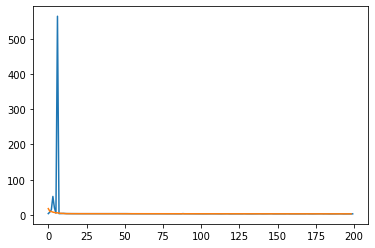

In [17]:
plt.plot(val_loss_list)
plt.plot(train_loss_list)
plt.legend

<function matplotlib.pyplot.legend(*args, **kwargs)>

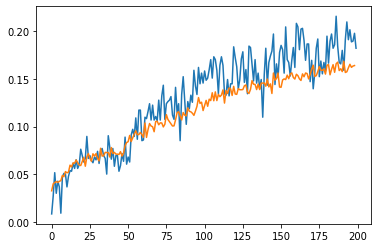

In [18]:
plt.plot(val_acc_list)
plt.plot(train_acc_list)
plt.legend

save_path = './weights_fujifilm_randomerase_600.pth'
torch.save(net.state_dict(),save_path)

In [26]:
load_path = './saved_prm/weights_fujifilm_randomerase_600_lr_0.0002.pth'
load_weights = torch.load(load_path)
net.load_state_dict(load_weights)


<All keys matched successfully>

In [20]:
net.eval()

DNet(
  (main): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.2, inplace=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.2, inplace=False)
    (10): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.2, inplace=False)
    (14): Conv2d(64

In [21]:
a = net(inputs.to('cuda'))
_, prediction = torch.max(a, 1)
print(prediction)
print(labels)

tensor([39, 17,  7, 33, 23,  7, 29, 17,  7,  7,  7, 33, 39, 22, 17, 23, 23, 17,
        17, 22, 22, 22,  7, 17, 17, 33, 17, 22,  7, 34,  8, 30],
       device='cuda:0')
tensor([25, 20, 19, 33,  5,  5, 33, 32, 23, 13,  4, 33,  5, 22,  5, 23, 23,  5,
        27, 16, 16, 25,  5, 16, 17, 17, 16, 18, 11, 23,  9, 36])


In [ ]:
batch_iterator2 = iter(dataloaders_dict["val"])  # イテレータに変換
inputs2, labels2 = next(batch_iterator) 
a = net(inputs2.to('cuda'))
_, prediction2 = torch.max(a, 1)
print(prediction2)
print(labels2)

In [ ]:
feature_fn = torch.nn.Sequential(*list(net.children())[:-2]).cpu()
classifier_fn = torch.nn.Sequential(*(list(net.children())[-2:-1] + [Flatten()] + list(net.children())[-1:]))

In [ ]:
def GradCam(img, c, feature_fn, classifier_fn):
    feats = feature_fn(img.cpu())
    _, N, H, W = feats.size()
    out = classifier_fn(feats.view(feats.size(0), -1))
    c_score = out[0, c]
    print(c_score)
    grads = torch.autograd.grad(c_score, feats)
    w = grads[0][0].mean(-1).mean(-1)
    sal = torch.matmul(w, feats.view(N, H*W))
    sal = F.relu(sal)
    sal = sal.view(H, W).cpu().detach().numpy()
    sal = np.maximum(sal, 0)
    return sal

In [ ]:
batch_iterator = iter(dataloaders_dict["val"])  # イテレータに変換
inputs, labels = next(batch_iterator)
input_data = inputs[0].view(1,3,256,256)


In [ ]:
nn.Softmax(dim=1)(net(input_data))

In [ ]:
pp, cc = torch.topk(nn.Softmax(dim=1)(net(input_data)), 2)

In [ ]:
sal = GradCam(input_data.cpu(), cc[0][0], feature_fn, classifier_fn)